In [1]:
from models.FF_1H import *
import torch
from main import *
from torch.utils.data import DataLoader
from utils.Standard_Norm import *
from sklearn.preprocessing import StandardScaler
torch.manual_seed(0)

In [2]:
training = np.load('data/large/YZ_Large_70.npz')['data']
training[:,-1]

array([-12131.30566186,   -753.54752103, -30103.19578924, ...,
       -16921.3155718 ,  -3201.28804094, -22758.90653479])

In [5]:
train_cost = training[:,-1]
scaler = StandardScaler()
scaler.fit(train_cost.reshape(-1,1))

StandardScaler()

In [3]:
import pickle
# with open('scaler.pkl', 'wb') as file:
#     pickle.dump(scaler, file)
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)


In [5]:
# train_tensor = norm_scale.transform(torch.from_numpy(np.load('data/large/YZ_Large_70.npz')['data']))
# test_tensor = norm_scale.transform(torch.from_numpy(np.load('data/large/YZ_Large_30.npz')['data']))
train_loader = DataLoader(AntDataset('data/large/scaled_cost/YZ_Large_70_Cost_Scaled.npz'), batch_size=64, shuffle=True)
test_loader = DataLoader(AntDataset('data/large/scaled_cost/YZ_Large_30_Cost_Scaled.npz'), batch_size=64, shuffle=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NN2(2048, 1, 8, 8, nn.ReLU).to(device)
lr = 1e-4
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
epoch = 100
train_loss, test_loss = train_and_evaluate(model, optimizer, criterion, train_loader, test_loader, epoch, device)

Epoch 1 - Train Loss: 0.1745, Test Loss: 0.0659
Epoch 2 - Train Loss: 0.0516, Test Loss: 0.0558
Epoch 3 - Train Loss: 0.0346, Test Loss: 0.0266
Epoch 4 - Train Loss: 0.0264, Test Loss: 0.0219
Epoch 5 - Train Loss: 0.0214, Test Loss: 0.0194
Epoch 6 - Train Loss: 0.0194, Test Loss: 0.0173
Epoch 7 - Train Loss: 0.0177, Test Loss: 0.0152
Epoch 8 - Train Loss: 0.0164, Test Loss: 0.0180
Epoch 9 - Train Loss: 0.0165, Test Loss: 0.0134
Epoch 10 - Train Loss: 0.0150, Test Loss: 0.0129
Epoch 11 - Train Loss: 0.0153, Test Loss: 0.0134
Epoch 12 - Train Loss: 0.0142, Test Loss: 0.0200
Epoch 13 - Train Loss: 0.0142, Test Loss: 0.0117
Epoch 14 - Train Loss: 0.0139, Test Loss: 0.0236
Epoch 15 - Train Loss: 0.0134, Test Loss: 0.0113
Epoch 16 - Train Loss: 0.0132, Test Loss: 0.0148
Epoch 17 - Train Loss: 0.0132, Test Loss: 0.0131
Epoch 18 - Train Loss: 0.0127, Test Loss: 0.0108
Epoch 19 - Train Loss: 0.0126, Test Loss: 0.0171
Epoch 20 - Train Loss: 0.0120, Test Loss: 0.0128
Epoch 21 - Train Loss: 0.0126

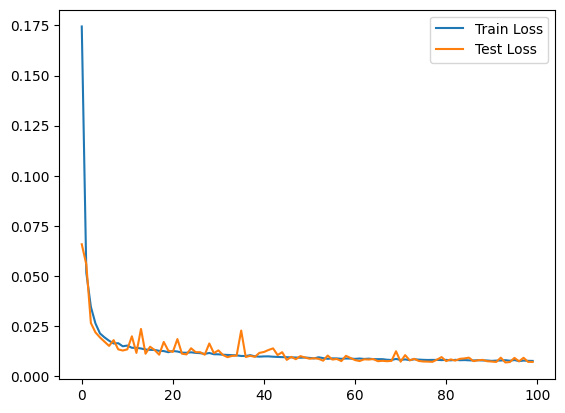

In [6]:
plt.plot(train_loss, label = 'Train Loss')
plt.plot(test_loss, label = 'Test Loss')
plt.legend()
plt.show()

In [7]:
import torch

# Define and train your PyTorch model
# ... Train and optimize the model ...

# Save the model's state dictionary or the entire model
torch.save(model.state_dict(), 'NN2_CostScaled_8_8_ReLU.pth')


In [8]:
import numpy as np
import pandas as pd

def process_csv_file(file_path):
    # Load the CSV file using pandas
    data_frame = pd.read_csv(file_path, header=None)

    # Extract the values and reshape into a numpy array
    array_data = data_frame.values.reshape(-1)[:1024]

    # Create the final numpy array of length 1024, padded with zeros if necessary
    final_array = np.zeros(1024)
    final_array[:array_data.shape[0]] = array_data

    return final_array

In [12]:
shape0 = np.hstack((process_csv_file('check_shapes/shape 0/Given Yant0.csv'), process_csv_file('check_shapes/shape 0/Given Zant0.csv')))
shape0_opt = np.hstack((process_csv_file('check_shapes/shape 0/Optimized Yant0.csv'), process_csv_file('check_shapes/shape 0/Optimized Zant0.csv')))
shape1 = np.hstack((process_csv_file('check_shapes/shape 1/Given Yant1.csv'), process_csv_file('check_shapes/shape 1/Given Zant1.csv')))
shape1_opt = np.hstack((process_csv_file('check_shapes/shape 1/Optimized Yant1.csv'), process_csv_file('check_shapes/shape 1/Optimized Zant1.csv')))
shape2 = np.hstack((process_csv_file('check_shapes/shape 2/Given Yant2.csv'), process_csv_file('check_shapes/shape 2/Given Zant2.csv')))
shape2_opt = np.hstack((process_csv_file('check_shapes/shape 2/Optimized Yant2.csv'), process_csv_file('check_shapes/shape 2/Optimized Zant2.csv')))


In [19]:
import torch
import numpy as np
import pickle

def pred_shape(model, inp, scale):
    inp = torch.from_numpy(inp).float()
    out = model(inp).detach().numpy()
    return scale.inverse_transform(out.reshape(-1,1)).flatten()


In [31]:
print(pred_shape(model, shape0, scaler))
print(pred_shape(model, shape0_opt, scaler))
print(pred_shape(model, shape1, scaler))
print(pred_shape(model, shape1_opt, scaler))
print(pred_shape(model, shape2, scaler))
print(pred_shape(model, shape2_opt, scaler))

[-12610.568]
[-21684.867]
[-6103.668]
[-17484.727]
[-7413.79]
[-20402.193]


In [20]:
def calculate_min_distance(ants, unit = 1):
    """
    Checks the smallest Euclidean distance, if it violates then return True
    """
    reshaped_tensor = torch.reshape(ants, (2, 1024))

# Transpose the reshaped tensor
    reshaped_tensor = torch.transpose(reshaped_tensor, 0, 1)
    nonzero_rows = torch.any(reshaped_tensor != 0, dim=1)
    filtered_tensor = reshaped_tensor[nonzero_rows]
    distances = torch.cdist(filtered_tensor, filtered_tensor)
    distances.fill_diagonal_(float('inf'))
    closest_neighbor_distances, _ = torch.min(distances, dim=1)
    smallest = torch.min(closest_neighbor_distances)
    return smallest.item()
    

In [32]:
def gradient_wrt_input(model, ants, lr, noise_std, iters):
    model.eval()
    last = None
    for i in range(iters):
        if ants.grad is not None:
            ants.requires_grad_()
            ants.grad.zero_()
        output = model(ants)
        output.backward()

        with torch.no_grad():
            last = ants.clone()
            noise = torch.rand_like(ants) * noise_std
            ants -= (lr * ants.grad * (ants != 0).float())
            if calculate_min_distance(ants) < 0.5:
                continue
        ants.grad.zero_()
    return ants


In [22]:
import matplotlib.pyplot as plt
def show_arrays(inp):
    data = inp.cpu().detach().numpy()
    reshaped_data = np.reshape(data, (2,1024))
    x = reshaped_data[0]
    y = reshaped_data[1]

    nonzero_ind = np.nonzero((x != 0) | (y != 0))
    x = x[nonzero_ind]
    y = y[nonzero_ind]

    plt.scatter(x,y, s=0.75)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Antenna Array Pattern')
    plt.show()

In [23]:
given_shapes =  np.zeros((20, 2048))#pd.DataFrame(columns=[f'y{i + 1}' for i in range(1024)] + [f'z{i + 1}' for i in range(1024)])
optimized_shapes = np.zeros((20, 2048)) #pd.DataFrame(columns=[f'y{i + 1}' for i in range(1024)] + [f'z{i + 1}' for i in range(1024)])
given_shapes_True_cost = []
given_shapes_pred_cost = []
optimized_shapes_pred_cost = []

In [ ]:
train_loader = DataLoader(AntDataset('data/large/scaled_cost/YZ_Large_70_Cost_Scaled.npz'))
i = 0
for inp, out in train_loader:
    if i == 20:
        break

    given_shapes_True_cost.append(out.item())
    given_shapes[i, :] = inp.flatten().numpy()
    inp, out = inp.to(device), out.to(device)

    inp_copy = inp.clone()
    inp_copy.requires_grad_()
    print(f'True Cost: {out}')
    show_arrays(inp)
    inp.requires_grad_()
    pred = model(inp)
    given_shapes_pred_cost.append(pred.item())
    print(f'Pred Cost: {pred}')
    print(calculate_min_distance(inp))
    optimized_inp = gradient_wrt_input(model, inp_copy,1e-2,1e-12, 10000)
    optimized_shapes[i, :] = optimized_inp.detach().flatten().cpu().numpy()
    optimized_inp.to(device)
    new_pred = model(optimized_inp)
    optimized_shapes_pred_cost.append(new_pred.item())
    print(f'New Pred: {new_pred}')
    show_arrays(optimized_inp)
    print(optimized_inp.shape)
    print(calculate_min_distance(optimized_inp))
    i += 1

In [233]:
columns = [f'y{i + 1}' for i in range(1024)] + [f'z{i + 1}' for i in range(1024)]
given_shapes_df = pd.DataFrame(given_shapes, columns=columns)
optimized_shapes_df = pd.DataFrame(optimized_shapes, columns=columns)

In [235]:
given_shapes_df.to_csv('given_shapes.csv', index = False)
optimized_shapes_df.to_csv('optimized_shapes.csv', index = False)

In [237]:
given_shapes_true_cost_df = pd.DataFrame({'True Cost': given_shapes_True_cost})
given_shapes_pred_cost_df = pd.DataFrame({'Predicted Cost': given_shapes_pred_cost})
optimized_shapes_pred_cost_df = pd.DataFrame({'Optimized Predicted Cost': optimized_shapes_pred_cost})

In [239]:
given_shapes_pred_cost_df.to_csv('given_shapes_pred_cost.csv', index = False)
given_shapes_true_cost_df.to_csv('given_shapes_true_cost.csv', index = False)
optimized_shapes_pred_cost_df.to_csv('optimized_shapes_pred_cost.csv', index = False)

In [4]:
data = np.load('data/large/large_YZant.npz')['arr_0']

In [2]:
small, large = np.load('data/large/scaled_cost/YZ_Large_30_Cost_Scaled.npz')['data'], np.load('data/large/scaled_cost/YZ_Large_70_Cost_Scaled.npz')['data']


In [6]:
stacked = np.vstack((small, large))

In [9]:
indices = np.argsort(stacked[:, -1])
best_10 = stacked[indices[:10]]

In [10]:
best_10

array([[-30.64484559, -29.70205211, -28.75925864, ...,   0.        ,
          0.        ,  -3.21482132],
       [-30.75978435, -29.21376344, -27.66774254, ...,   0.        ,
          0.        ,  -3.15755776],
       [-31.07106781, -29.65685425, -28.24264069, ...,   0.        ,
          0.        ,  -3.13994073],
       ...,
       [-30.38340047, -28.72046124, -27.05752202, ...,   0.        ,
          0.        ,  -3.02542015],
       [-30.64484559, -29.70205211, -28.75925864, ...,   0.        ,
          0.        ,  -3.02417421],
       [-30.38340047, -28.72046124, -27.05752202, ...,   0.        ,
          0.        ,  -3.01451864]])

In [12]:
columns = [f'y{i + 1}' for i in range(1024)] + [f'z{i + 1}' for i in range(1024)] + ['True Cost']
top_10_arrays = pd.DataFrame(best_10, columns=columns)
top_10_arrays

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,z1016,z1017,z1018,z1019,z1020,z1021,z1022,z1023,z1024,True Cost
0,-30.644846,-29.702052,-28.759259,-30.766590,-29.823797,-28.881003,-27.938210,-26.995416,-26.052623,-29.945541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.214821
1,-30.759784,-29.213763,-27.667743,-31.037019,-29.490998,-27.944977,-26.398956,-24.852935,-23.306914,-29.768232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.157558
2,-31.071068,-29.656854,-28.242641,-26.828427,-31.071068,-29.656854,-28.242641,-26.828427,-25.414214,-24.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.139941
3,-30.759784,-29.213763,-27.667743,-31.037019,-29.490998,-27.944977,-26.398956,-24.852935,-23.306914,-29.768232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.108225
4,-30.759784,-29.213763,-27.667743,-31.037019,-29.490998,-27.944977,-26.398956,-24.852935,-23.306914,-29.768232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.103843
5,-29.945541,-28.181698,-26.417856,-30.766590,-29.002747,-27.238905,-25.475062,-23.711220,-21.947377,-29.823797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.098636
6,-30.383400,-28.720461,-27.057522,-30.935199,-29.272260,-27.609321,-25.946382,-24.283442,-22.620503,-29.824059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.061418
7,-30.383400,-28.720461,-27.057522,-30.935199,-29.272260,-27.609321,-25.946382,-24.283442,-22.620503,-29.824059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.025420
8,-30.644846,-29.702052,-28.759259,-30.766590,-29.823797,-28.881003,-27.938210,-26.995416,-26.052623,-29.945541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.024174
9,-30.383400,-28.720461,-27.057522,-30.935199,-29.272260,-27.609321,-25.946382,-24.283442,-22.620503,-29.824059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.014519


In [14]:
top_10_arrays.to_csv('top_10_arrays.csv', index=False)

In [29]:
# Load model
model = NN2(2048, 1, 8, 8, nn.ReLU)
model.load_state_dict(torch.load('weights/NN2_CostScaled_8_8_ReLU.pth'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

NN2(
  (regressor): Sequential(
    (0): Linear(in_features=2048, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [34]:
given_shapes =  np.zeros((10, 2048))#pd.DataFrame(columns=[f'y{i + 1}' for i in range(1024)] + [f'z{i + 1}' for i in range(1024)])
optimized_shapes = np.zeros((10, 2048)) #pd.DataFrame(columns=[f'y{i + 1}' for i in range(1024)] + [f'z{i + 1}' for i in range(1024)])
given_shapes_True_cost = []
given_shapes_pred_cost = []
optimized_shapes_pred_cost = []

In [35]:

train_loader = DataLoader(AntDataset(best_10))
i = 0
for inp, out in train_loader:

    given_shapes_True_cost.append(out.item())
    given_shapes[i, :] = inp.flatten().numpy()
    inp, out = inp.to(device), out.to(device)

    inp_copy = inp.clone()
    inp_copy.requires_grad_()
    print(f'True Cost: {out}')
    inp.requires_grad_()
    pred = model(inp)
    given_shapes_pred_cost.append(pred.item())
    print(f'Pred Cost: {pred}')
    optimized_inp = gradient_wrt_input(model, inp_copy,1e-2,1e-12, 10000)
    optimized_shapes[i, :] = optimized_inp.detach().flatten().cpu().numpy()
    optimized_inp.to(device)
    new_pred = model(optimized_inp)
    optimized_shapes_pred_cost.append(new_pred.item())
    print(f'New Pred: {new_pred}')
    i += 1

True Cost: tensor([-3.2148], device='cuda:0')
Pred Cost: tensor([[-2.7861]], device='cuda:0', grad_fn=<AddmmBackward0>)
New Pred: tensor([[-4.5998]], device='cuda:0', grad_fn=<AddmmBackward0>)
True Cost: tensor([-3.1576], device='cuda:0')
Pred Cost: tensor([[-2.6941]], device='cuda:0', grad_fn=<AddmmBackward0>)
New Pred: tensor([[-3.9437]], device='cuda:0', grad_fn=<AddmmBackward0>)
True Cost: tensor([-3.1399], device='cuda:0')
Pred Cost: tensor([[-2.7631]], device='cuda:0', grad_fn=<AddmmBackward0>)
New Pred: tensor([[-3.7884]], device='cuda:0', grad_fn=<AddmmBackward0>)
True Cost: tensor([-3.1082], device='cuda:0')
Pred Cost: tensor([[-2.8222]], device='cuda:0', grad_fn=<AddmmBackward0>)
New Pred: tensor([[-3.9638]], device='cuda:0', grad_fn=<AddmmBackward0>)
True Cost: tensor([-3.1038], device='cuda:0')
Pred Cost: tensor([[-2.8985]], device='cuda:0', grad_fn=<AddmmBackward0>)
New Pred: tensor([[-4.1084]], device='cuda:0', grad_fn=<AddmmBackward0>)
True Cost: tensor([-3.0986], device